## CCA vs Linear CKA

In the first experiment, we wanted to replace the CCA metric with Linear CKA because it was computationally better. To do this, we compared whether the results obtained by https://arxiv.org/abs/2107.04734 using CCA were similar if we switched to Linear CKA.

In [17]:
from tqdm import tqdm
import os
import json
import numpy as np
from scipy import stats
import matplotlib.pyplot as plt
from sklearn.cross_decomposition import CCA
from pathlib import Path

In [18]:
def linear_CKA(X, Y):
    X_centered = X - X.mean(axis=0)
    Y_centered = Y - Y.mean(axis=0)
    hsic = np.linalg.norm(X_centered.T @ Y_centered, 'fro') ** 2
    var1 = np.linalg.norm(X_centered.T @ X_centered, 'fro')
    var2 = np.linalg.norm(Y_centered.T @ Y_centered, 'fro')

    return hsic / (var1 * var2)

In [19]:
with open('/home/cbolanos/experiments/layers/embeddings_layer0_glove.json', 'r') as f:
    glove_list = json.load(f)
glove_matrix = np.array(glove_list)

# Commented because we already have the results 

# wav_vs_glove = []
# for i in range(12):
#     with open(os.path.join('../../..', 'experiments', 'layers', f'embeddings_layer{i}_wav2vec2.json'), 'r') as f:
#         model1_list = json.load(f)
#     model1_matrix = np.array(model1_list)
#     wav_vs_glove.append(linear_CKA(model1_matrix, glove_matrix)) 

#     del model1_list, model1_matrix
#     gc.collect()
   
# with open(f'cka_glove_wav2vec2.json', 'w') as f:
#     json.dump(wav_vs_glove, f)

In [20]:
file_path = Path('cka_glove_wav2vec2.json')

with file_path.open('r', encoding='utf-8') as file:
    wav_vs_glove = json.load(file)

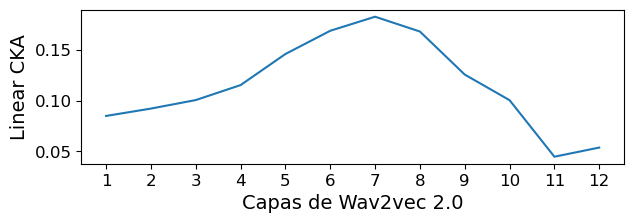

In [29]:
x = range(1, 13)
plt.figure(figsize=(7, 2))
plt.plot(x, wav_vs_glove)

plt.xlabel('Capas de Wav2vec 2.0', fontsize=14)  
plt.ylabel('Linear CKA', fontsize=14)  
plt.xticks(range(1, 13), fontsize=12)  
plt.yticks(fontsize=12)  
plt.show()


## Linear CKA: increasing with the amount of data

In [22]:
x_list = []
for i in range(12):
    with open(os.path.join('/home/cbolanos/', 'experiments', 'layers', f'embeddings_layer{i}_wav2vec2.json'), 'r') as f:
        model1_list = json.load(f)
    x_matrix = np.array(model1_list)
    x_list.append(x_matrix) 


In [23]:
matrix = np.zeros((13, 12))
vector = [50, 100, 500, 1000, 2000, 3000, 9000, 15000, 21000, 30000, 36000, 39000, 45000]
for i in range(len(vector)):
    for j in tqdm(range(12)): 
        x = x_list[j]
        matrix[i, j] = linear_CKA(x[0:vector[i]], glove_matrix[0:vector[i]])

100%|██████████| 12/12 [00:03<00:00,  3.49it/s]


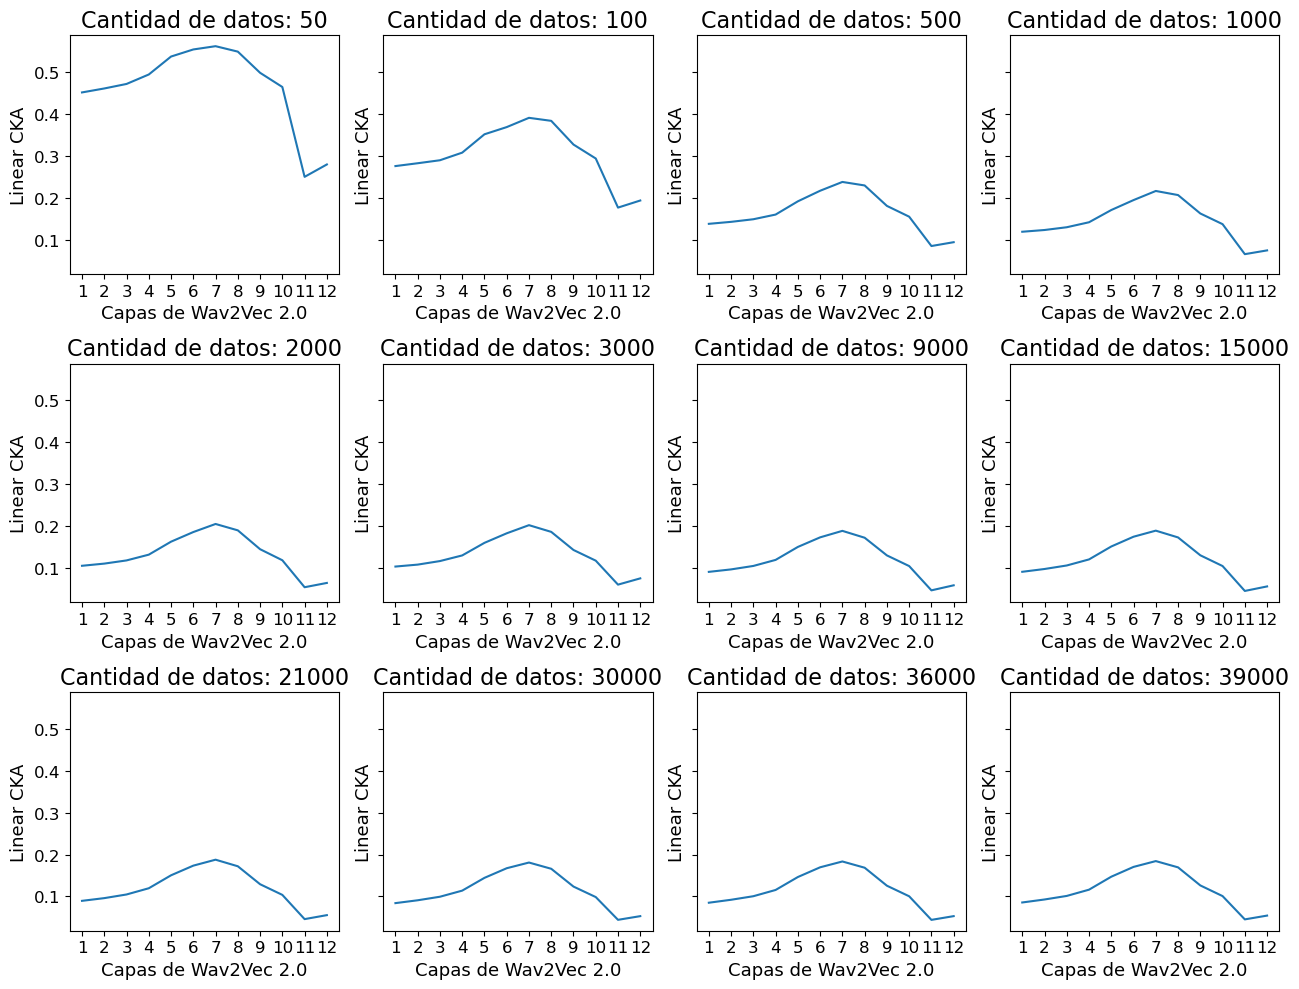

In [24]:
fig, axes = plt.subplots(nrows=3, ncols=4, figsize=(13, 10), sharey=True)

axes = axes.flatten()

for i in range(12):
    x = range(1, 13)  # Layers 1 to 12
    axes[i].plot(x, matrix[i], label='wav_vs_glove')
    axes[i].set_xlabel('Capas de Wav2Vec 2.0', fontsize=13)  
    axes[i].set_ylabel('Linear CKA', fontsize=13)  
    axes[i].set_title(f'Cantidad de datos: {vector[i]}', fontsize=16) 
    axes[i].set_xticks(range(1, 13)) 
    axes[i].tick_params(axis='both', which='major', labelsize=12)  

plt.tight_layout()
plt.show()


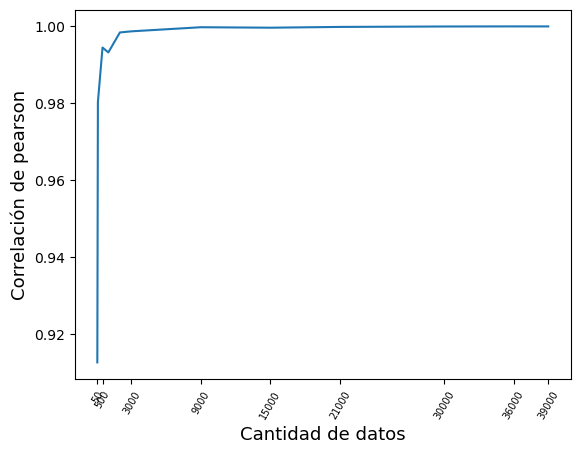

In [25]:
pearson_corr = []
for j in range(matrix.shape[0]-1):
    pearson_corr.append(stats.pearsonr(wav_vs_glove, matrix[j]).statistic)

vector = [50, 100, 500, 1000, 2000, 3000, 9000, 15000, 21000, 30000, 36000, 39000]

plt.plot(vector, pearson_corr)
plt.xlabel('Cantidad de datos',  fontsize=13)
plt.ylabel('Correlación de pearson', fontsize=13)
plt.xticks([50, 500, 3000, 9000, 15000, 21000, 30000, 36000, 39000],  rotation=60, fontsize=7)
plt.show()

## CKA vs CCA

In [23]:
# # Running this cell in Colab because we don't have enough computational resources locally resulted in an error due to insufficient compute power.

# import os
# os.environ['OMP_NUM_THREADS']='8' #Cantidad de threads a usar por sklearn
# os.nice(10) #Prioridad de los procesos -20: highest 20: lowest 0: default

# wav_vs_glove_CCA = []
# with open(os.path.join('../experiments/layers/embeddings_layer0_glove.json'), 'r') as f:
#     glove_list = json.load(f)
# glove_matrix = np.array(glove_list)

# for i in range(12):
#     x = x_list[i]
#     model1_matrix = np.array(model1_list)
#     model = CCA(n_components=300)
#     model.fit(x[0:3000],glove_matrix[0:3000])
#     X_c, Y_c = model.transform(x[0:3000], glove_matrix[0:3000])
#     correlations = np.corrcoef(X_c.T, Y_c.T).diagonal(offset=X_c.shape[1])
#     mean_correlation = np.mean(correlations)
#     wav_vs_glove_CCA.append(mean_correlation)  

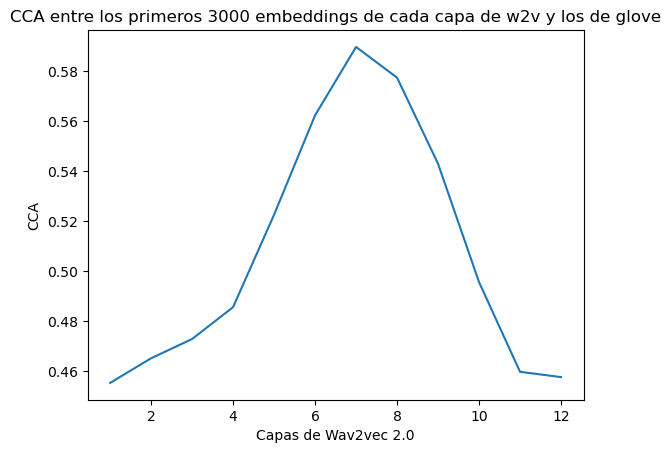

In [26]:
wav_vs_glove_CCA = [0.4552785903820065,
 0.46515271583991935,
 0.4728577455210156,
 0.4856241870508816,
 0.52264089080444,
 0.5624277531077105,
 0.5898141105294815,
 0.5775077350128057,
 0.5430461697056727,
 0.49564927266548353,
 0.45973128155226173,
 0.4576064483370868]

x = range(1,13)
plt.plot(x, wav_vs_glove_CCA, label='wav_vs_glove')

plt.xlabel('Capas de Wav2vec 2.0')
plt.ylabel('CCA')
plt.title('CCA entre los primeros 3000 embeddings de cada capa de w2v y los de glove')
plt.show()

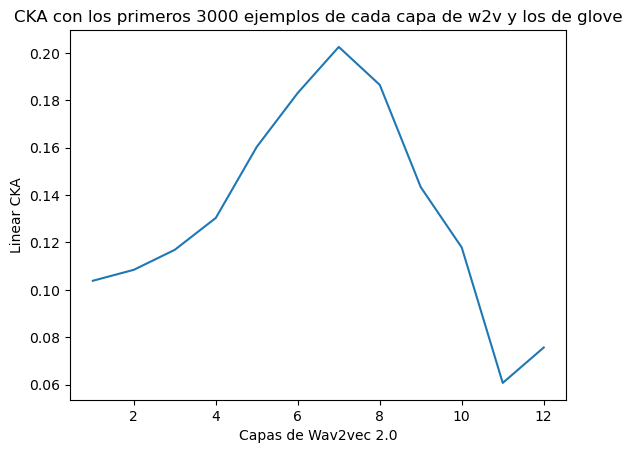

In [27]:
x = range(1,13)
plt.plot(x, matrix[5], label='wav_vs_glove')

plt.xlabel('Capas de Wav2vec 2.0')
plt.ylabel('Linear CKA')
plt.title('CKA con los primeros 3000 ejemplos de cada capa de w2v y los de glove')
plt.show()

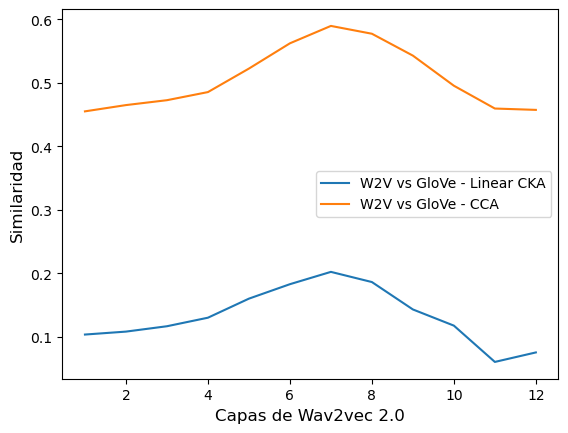

In [24]:
x = range(1,13)
plt.plot(x, matrix[5], label='W2V vs GloVe - Linear CKA')
plt.plot(x, wav_vs_glove_CCA, label='W2V vs GloVe - CCA')

plt.xlabel('Capas de Wav2vec 2.0', fontsize=13)
plt.ylabel('Similaridad',  fontsize=13)
plt.legend()
plt.show()